# In this Notebook, we will work on the [**Medical Scan Classification** Dataset](https://www.kaggle.com/datasets/arjunbasandrai/medical-scan-classification-dataset)  

##### Note: This notebook runs **only** on Kaggle, the file paths and directories are configured for Kaggle.. running the code cells won't work unless the dataset is available _locally_ and file paths correctly corresponds to system directories.  

This dataset is all just pictures of **oral** samples of patients and non-patients, a good way to implement a model to capture the underlying patterns of images is a `Convolutional Neural Networks`**`CNN`**. We can also try to use a **pre-trained model**, `transfer learning technique`.  

First, let's import necessary libraries:  

In [1]:
import kagglehub
import os
import absl.logging
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from keras.layers import RandomFlip, RandomContrast, RandomRotation, RandomZoom
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

path = kagglehub.dataset_download("arjunbasandrai/medical-scan-classification-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/medical-scan-classification-dataset


Now let's make use of the multiple GPUs **GPU T4** available at kaggle by making a new `strategy` that _mirrors_ the training to both devices, i.e. GPUs.  

##### Don't worry about the first 4 lines of code, it's used to silence logs appearing in the console.

In [2]:
sys.stderr = open('/dev/null', 'w')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
absl.logging.set_verbosity(absl.logging.ERROR)
tf.debugging.set_log_device_placement(False)

strategy = tf.distribute.MirroredStrategy()
print(f'DEVICES AVAILABLE: {strategy.num_replicas_in_sync}')

DEVICES AVAILABLE: 2


## 1- Data Preprocessing  

It's important to know the structure of the dataset: _you can view it by enabling sidebar from the `view` menu_.  
Now let's split the data to $70\%$ training, $15\%$ validation, $15\%$ testing. using `train_test_split` function from `sklearn`. In order for this to work we need to have a **_list_** or a **_np.ndarray_** to be able to split it. Then we create a **preprocessing pipeline** for input data, which are images, in order to format it efficiently for model training and evaluation, this can be done by mapping image paths and labels to the preprocessing pipeline, so every batch during the creation of train, test and validation sets gets preprocessed first before being transformed into numpy arrays. As following:  

In [3]:
dir_path = "/kaggle/input/medical-scan-classification-dataset/Oral Cancer/Oral Cancer/"
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
SEED = 42

# Collecting image paths and labels:
image_paths, labels = [], []
for class_name in ['Normal', 'Squamous Cell Carcinoma']:
    class_path = os.path.join(dir_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_paths.append(image_path)
        labels.append(class_name)

label_encoder = LabelEncoder() # Encoding labels to 0s and 1s 
labels_encoded = label_encoder.fit_transform(labels)

image_paths_train, image_paths_temp, y_train_encoded, y_temp_encoded = train_test_split(image_paths, labels_encoded, 
                                                                                        test_size=0.3, random_state=SEED)
image_paths_val, image_paths_test, y_val_encoded, y_test_encoded = train_test_split(image_paths_temp, y_temp_encoded, 
                                                                                    test_size=0.5, random_state=SEED)

# Preprocessing pipeline:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, y_train_encoded))
train_dataset = train_dataset.map(preprocess_image).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_paths_val, y_val_encoded))
val_dataset = val_dataset.map(preprocess_image).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, y_test_encoded))
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE)

In [4]:
# Converting `tf.data.Dataset` objects into `np.ndarray`
def dataset_to_numpy(dataset):
    features_list = []
    labels_list = []
    
    for batch in dataset:
        features, labels = batch
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())

    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7001, 224, 224, 3),
 (7001,),
 (1500, 224, 224, 3),
 (1500,),
 (1501, 224, 224, 3),
 (1501,))

We need to rescale the input samples to be $224\times224$ as many pre-trained CNN models work with this input size. We also want to _augment_ the data as it increases the diversity of the data, helping the model to generalize well. We can do so using `RandomFlip`, `RandomRotation`, `RandomZoom` and `RandomContrast` preprocessing layers according the **`Sequential`** model structure shown below.   

## 2- Building the model  

For image classification, a **CNN** model is ideal, or we could also use a pre-trained model like **DenseNet121** as we'll discuss later.  
A **`Conv2D`** layer is what makes a neural network _convolutional_, it also reduces the number of trainable parameters compared to fully connected **`Dense`** layer.  

A **`BatchNormalization`** layer is often used after a `Conv2D` layer to standardize its activation functions, which leads to faster training by keeping the distribution more stable. It also help make the model generalize well if it's overfitting.  

A **`MaxPooling2D`** layer is essential as it downsamples the spatial dimentions, _height and width_  from the previous layers, while preserving the features. It also prevents overfitting as it reduces the number of parameters.  

A **`Flatten`** layer is used after finishing the custom CNN layers to flatten out the **2D** dimensions into a **1D** feature vector, which is a necessary transformation before feeding the data into a `Dense` layer, _fully connected NN_.  

A **`Dropout`** layer is used to randomly _drop out_ some of the neurons during training. It helps the model generalize better, but in most application when using `BatchNormalization` layers, it's not mandatory to dropout most of the neurons.  

In [5]:
model = Sequential([
    Input(shape=INPUT_SHAPE), 
    
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2, 0.2),
    RandomContrast(0.2),
     
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
        
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
        
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
        
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
        
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.35),
    BatchNormalization(), 
        
    Dropout(0.35),
    Dense(1, activation='sigmoid'), ])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │              

 Total params: 4,784,577 (18.25 MB)

 Trainable params: 4,782,337 (18.24 MB)

 Non-trainable params: 2,240 (8.75 KB)

## 3- Compiling the model  

We're using the `adam` optimizer as it's a standard efficient optimizer for most ML and DL applications.  
We're monitoring the `accuracy` of the model as it helps get a generalized idea of how good the model is, _even if we care more about **recall** in such tasks_.  

In [ ]:
adam = Adam(learning_rate=5e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## 4- Training the model  

We're using the `EarlyStopping` technique to avoid the model overfitting the data over a large number of epochs, and then restoring its best parameter depending on lowest `validation_loss`. We're also specifying a **dynamic learning rate** using `ReduceLROnPlateau`, by initailizing learning rate to a specific value, like $5\times10^{-4}$, and specifying the minimum learning rate it can reach, in our case $10^{-6}$, while also specifying the _reduction factor_ at which the LR is reduced after pre-specified number of _epochs_. As following:  

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                 patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE, callbacks=[early_stopping, lr_scheduler])

print(f"Best validation accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")

Epoch 1/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.6417 - loss: 0.7640 - val_accuracy: 0.5173 - val_loss: 1.3451 - learning_rate: 5.0000e-04
Epoch 2/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.7383 - loss: 0.5507 - val_accuracy: 0.6240 - val_loss: 0.7480 - learning_rate: 5.0000e-04
Epoch 3/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.7779 - loss: 0.4681 - val_accuracy: 0.7753 - val_loss: 0.4578 - learning_rate: 5.0000e-04
Epoch 4/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.7832 - loss: 0.4595 - val_accuracy: 0.8160 - val_loss: 0.4007 - learning_rate: 5.0000e-04
Epoch 5/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.7996 - loss: 0.4299 - val_accuracy: 0.7547 - val_loss: 0.4525 - learning_rate: 5.0000e-04
Epoch 6/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.8308 - loss: 0.3758 - val_accuracy: 0.7473 - val_loss: 0.6172 - learning_rate: 5.0000e-04
Epoch 7/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 15

## 5- Model evaluation

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Loss: 1.345131516456604, Accuracy: 98.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       764
           1       0.97      0.99      0.98       737

    accuracy                           0.98      1501
   macro avg       0.98      0.98      0.98      1501
weighted avg       0.98      0.98      0.98      1501



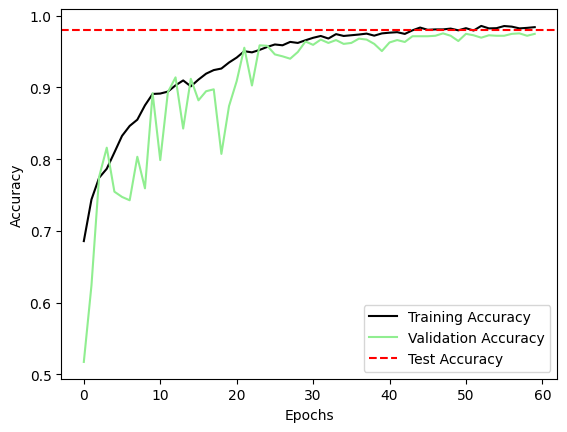

In [7]:
y_pred_probs = model.predict(X_test, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']
print(f"Loss: {max(history.history['val_loss'])}, Accuracy: {accuracy*100:0.2f}%")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lightgreen')
plt.axhline(y=accuracy, color='red', linestyle='--', label="Test Accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Let's plot the **confusion matrix** to see if our classes are balanced across the datasets:  

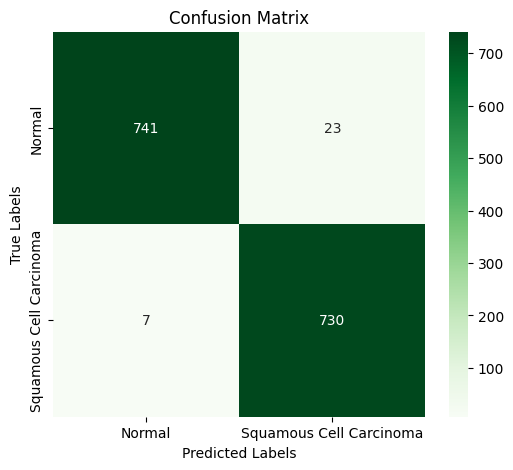

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal', 'Squamous Cell Carcinoma'], yticklabels=['Normal', 'Squamous Cell Carcinoma'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Now let's try to use a `Transfer Learning` technique, by using a pre-trained model tailored for medical applications like `DenseNet121`.  
We will use the same data augmentation technique

In [9]:
def create_model(base_model):
    input = Input(shape=INPUT_SHAPE)
    
    x = RandomFlip('horizontal')(input)
    x = RandomRotation(0.15)(x)
    x = RandomZoom(0.15,0.15)(x)
    x = RandomContrast(0.15)(x)
    x = base_model(x)
    
    x = GlobalAveragePooling2D()(x)  # No Flatten needed
    x = Dense(256)(x)
    x = BatchNormalization()(x)  # Placed before activation
    x = tf.keras.layers.Activation('relu')(x)
    x = Dense(1, activation='sigmoid')(x)  
    
    model = Model(inputs=input, outputs=x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Now let's build the model using the `MirroredStrategy` we defined earlier to be able to use our GPUs efficiently: 

In [10]:
with strategy.scope():
    base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    fine_tuned_model = create_model(base_model)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                 patience=5, min_lr=1e-6)

history = fine_tuned_model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val),
                               batch_size=BATCH_SIZE, callbacks=[early_stopping, lr_scheduler])

print(f"Best validation accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")

Epoch 1/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 60s 173ms/step - accuracy: 0.7495 - loss: 0.5110 - val_accuracy: 0.7973 - val_loss: 0.4682 - learning_rate: 0.0010
Epoch 2/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.8357 - loss: 0.3605 - val_accuracy: 0.8493 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 3/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.8558 - loss: 0.3272 - val_accuracy: 0.8120 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 4/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.8714 - loss: 0.2967 - val_accuracy: 0.8880 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 5/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.8874 - loss: 0.2710 - val_accuracy: 0.9013 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 6/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.8887 - loss: 0.2680 - val_accuracy: 0.9013 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 7/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.9

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step
Loss: 0.468240350484848, Accuracy: 96.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       764
           1       0.96      0.97      0.97       737

    accuracy                           0.97      1501
   macro avg       0.97      0.97      0.97      1501
weighted avg       0.97      0.97      0.97      1501



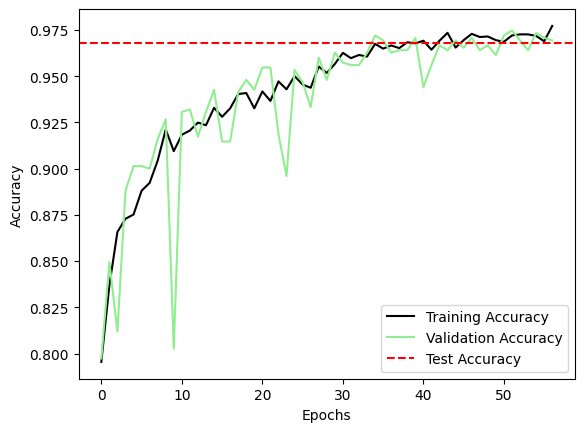

In [12]:
y_pred_probs = fine_tuned_model.predict(X_test, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']
print(f"Loss: {max(history.history['val_loss'])}, Accuracy: {accuracy*100:0.2f}%")

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lightgreen')
plt.axhline(y=accuracy, color='red', linestyle='--', label="Test Accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

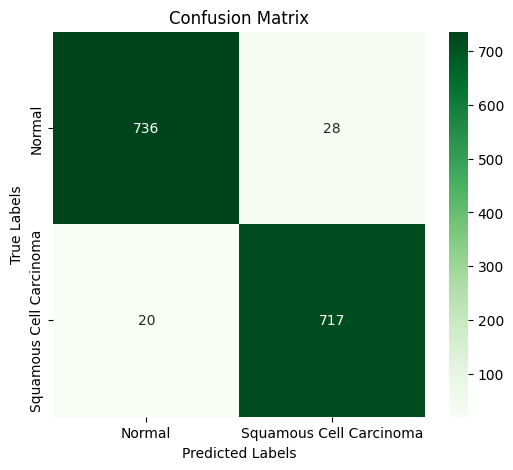

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal', 'Squamous Cell Carcinoma'], yticklabels=['Normal', 'Squamous Cell Carcinoma'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
model.save('/kaggle/working/oral_classifier.keras', save_format="keras")